# Bayesian MNN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import time
import pickle

import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from BayesianNN import BayesianRegressorWrapper, RegressionSampler

from Data_processing import data_processing
import scipy.io as sio
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
def extract_data(data):
    data = [data_processing(data[i], 4) for i in range(len(data))]
    X, Y = list(zip(*data))
    X = torch.tensor(np.concatenate(X, axis=0)).type(torch.float)
    Y = torch.tensor(np.concatenate(Y, axis=0)).type(torch.float)
    return X, Y

In [3]:
relu = torch.relu
sigmoid = torch.sigmoid

class MatrixLayer(nn.Module):
    def __init__(self, input_dims, output_dims, activation=None):
        super().__init__()
        
        assert len(input_dims) == len(output_dims) == 2
        
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.activation = activation
        
        self.U = nn.Parameter(torch.empty([output_dims[0], input_dims[0]]))
        self.V = nn.Parameter(torch.empty([input_dims[1], output_dims[1]]))        
        self.B = nn.Parameter(torch.empty(output_dims))
        
        torch.nn.init.kaiming_normal_(self.U)
        torch.nn.init.kaiming_normal_(self.V)
        torch.nn.init.kaiming_normal_(self.B)
        
    def forward(self, i):
        x = torch.matmul(torch.matmul(self.U, i), self.V) + self.B
        if self.activation is None:
            return x
        return self.activation(x)
    
class BaseNetwork(nn.Module):
    def __init__(self, input_dims, hidden1_dims, hidden2_dims, output_dims):
        super().__init__()
        self.mat1 = MatrixLayer(input_dims, hidden1_dims, sigmoid)
        self.mat2 = MatrixLayer(hidden1_dims, hidden2_dims, sigmoid)
        self.mat3 = MatrixLayer(hidden2_dims, output_dims, None)
        
    def forward(self, i):
        x = self.mat1(i)
        x = self.mat2(x)
        return self.mat3(x)

### DATA

In [4]:
train = sio.loadmat('data/cytrack_train.mat')
train = train['cyclones_train']
train_final = train[0]

test = sio.loadmat('data/cytrack_test.mat')
test = test['cyclones_test']
test_final = test[0]

X_train, Y_train = extract_data(train_final)
X_test, Y_test = extract_data(test_final)

### Load params
- Use code below if training was interrupted

In [5]:
def load_params(sampler, folder, i, update_dist=False):
    with (open(f"{folder}/w_samples_{i}.pickle", "rb")) as file:
        w_samples = pickle.load(file)
        w_last = w_samples[-1]
    
    with (open(f"{folder}/tausq_samples_{i}.pickle", "rb")) as file:
        tausq_samples = pickle.load(file)
        tausq_last = tausq_samples[-1]
    
    if update_dist:
        sampler.update_param_dist(w_samples)
    sampler.chain_initialiser(w_last, tausq_last)

### TRAINING
- Saves results every 1000 epochs

In [6]:
# torch.manual_seed(1)
base_model = BaseNetwork([4, 2], [25, 8], [50, 10], [1, 2])
bayesian_model = BayesianRegressorWrapper(base_model)
sampler = RegressionSampler(bayesian_model, X_train, Y_train, X_test, Y_test)
# load_params(sampler, "samples 29-12-2020", 5)

In [13]:
# j = 1
start = time.time()

epochs = 5000
for i in range(epochs):
    sampler.sample(evaluate_on_test=True)
#     losses.append(loss); test_losses.append(test_loss)
    
#     if (i + 1) % 1000 == 0:
#         save_results(sampler, 'samples', j)
#         j += 1

    if (i + 1) % (int(epochs / 10)) == 0:
        print(f"Done {i + 1} / {epochs}")
        print(f"Time taken: {np.round(time.time() - start, 2)}")
        print(f'Acceptance rate: {sampler.accept_counter / (i + 1)}')
        

end = time.time()  
print(f"Time taken: {np.round(end - start, 2)}s")
print(f'Acceptance rate: {sampler.accept_counter / epochs}')
# sampler.update_param_dist()

Done 500 / 5000
Time taken: 137.27
Acceptance rate: 0.356
Done 1000 / 5000
Time taken: 293.0
Acceptance rate: 0.315
Done 1500 / 5000
Time taken: 489.15
Acceptance rate: 0.29
Done 2000 / 5000
Time taken: 661.28
Acceptance rate: 0.2505
Done 2500 / 5000
Time taken: 799.05
Acceptance rate: 0.22
Done 3000 / 5000
Time taken: 940.58
Acceptance rate: 0.195
Done 3500 / 5000
Time taken: 1083.16
Acceptance rate: 0.1742857142857143
Done 4000 / 5000
Time taken: 1224.89
Acceptance rate: 0.1585
Done 4500 / 5000
Time taken: 1375.33
Acceptance rate: 0.14422222222222222
Done 5000 / 5000
Time taken: 1511.5
Acceptance rate: 0.1324
Time taken: 1511.58s
Acceptance rate: 0.1324


### Plot results

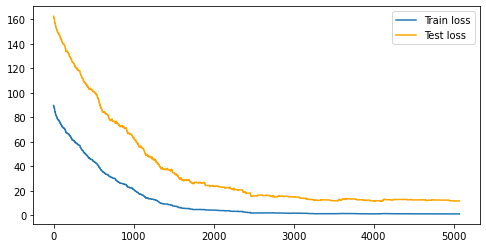

In [19]:
burn_in = 0

plt.figure(figsize=(8, 4))
plt.plot(sampler.container.loss_list[burn_in:], label="Train loss")
plt.plot(sampler.container.test_loss_list[burn_in:], label="Test loss", color="orange")
plt.legend()

### Evaluation

In [7]:
load_params(sampler, 'samples 29-12-2020', 5, update_dist=True)

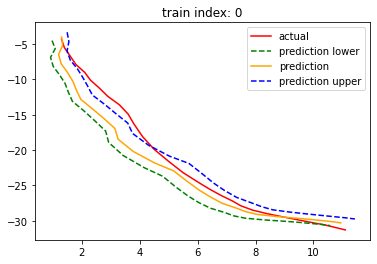

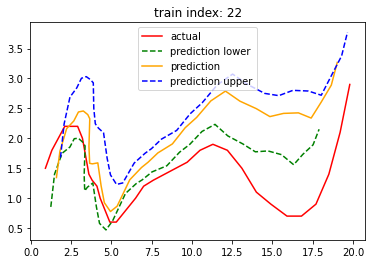

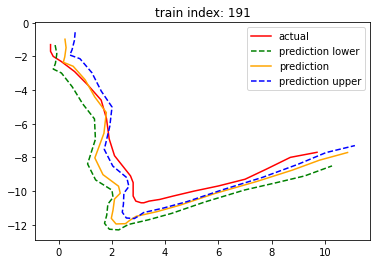

In [9]:
for i in range(3):
    idx = np.random.randint(0, len(train_final))
    X_new, Y_new = data_processing(train_final[idx], 4)
    X_new = torch.tensor(X_new).type(torch.float)
    Y_new = torch.tensor(Y_new).type(torch.float).view(-1, 2)
    Y_new_pred = bayesian_model.compute_pred_dist(X_new)
    
    Y_new_pred_np = np.array([Y_new_pred[i].view(-1, 2).detach().numpy() for i in range(len(Y_new_pred))])

    lower = np.percentile(Y_new_pred_np, axis=0, q=2.5)
    mean = Y_new_pred_np.mean(axis=0)
    upper = np.percentile(Y_new_pred_np, axis=0, q=97.5)
    
    plt.figure()
    plt.title(f"train index: {idx}")
    plt.plot(Y_new[:, 0].numpy(), Y_new[:, 1].numpy(), color="red", label="actual")
    plt.plot(lower[:, 0], lower[:, 1], linestyle='dashed', color="green", label="prediction lower")
    plt.plot(mean[:, 0], mean[:, 1], label="prediction", color="orange")
    plt.plot(upper[:, 0], upper[:, 1], linestyle='dashed', color="blue", label="prediction upper")
    plt.legend()

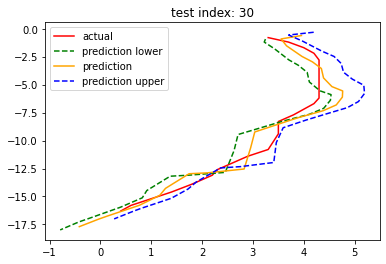

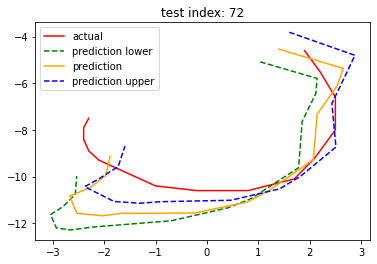

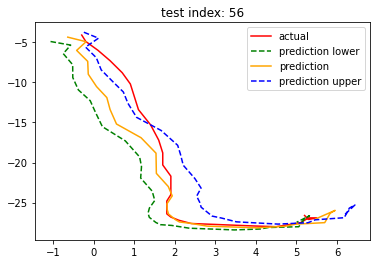

In [10]:
for i in range(3):
    idx = np.random.randint(0, len(test_final))
    X_new, Y_new = data_processing(test_final[idx], 4)
    X_new = torch.tensor(X_new).type(torch.float)
    Y_new = torch.tensor(Y_new).type(torch.float).view(-1, 2)
    Y_new_pred = bayesian_model.compute_pred_dist(X_new)
    
    Y_new_pred_np = np.array([Y_new_pred[i].view(-1, 2).detach().numpy() for i in range(len(Y_new_pred))])

    lower = np.percentile(Y_new_pred_np, axis=0, q=2.5)
    mean = Y_new_pred_np.mean(axis=0)
    upper = np.percentile(Y_new_pred_np, axis=0, q=97.5)
    
    plt.figure()
    plt.title(f"test index: {idx}")
    plt.plot(Y_new[:, 0].numpy(), Y_new[:, 1].numpy(), color="red", label="actual")
    plt.plot(lower[:, 0], lower[:, 1], linestyle='dashed', color="green", label="prediction lower")
    plt.plot(mean[:, 0], mean[:, 1], label="prediction", color="orange")
    plt.plot(upper[:, 0], upper[:, 1], linestyle='dashed', color="blue", label="prediction upper")
    plt.legend()

### Non-Bayesian

In [ ]:
# model = BaseNetwork([4, 2], [25, 8], [50, 10], [1, 2])
# criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# epochs = 1000
# losses = []
# test_losses = []
# for i in range(epochs):
#     Y_pred_train = model(X_train)
#     loss = criterion(Y_pred_train, Y_train)
#     losses.append(loss.item())
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     Y_pred_test = model(X_test)
#     test_loss = criterion(Y_pred_test, Y_test)
#     test_losses.append(test_loss.item())
    
#     if (i + 1) % (int(epochs / 10)) == 0:
#         print(f"Done {i + 1} / {epochs}")
#         print(loss)
#         print(test_loss)